In [1]:

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, desc, count, rank
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

spark = SparkSession.builder.appName("Movie-Capstone").getOrCreate()

users_data = [
    (1, "Rahul", 25, "Bangalore"),
    (2, "Priya", 30, "Delhi"),
    (3, "Aman", 22, "Hyderabad"),
    (4, "Sneha", 28, "Chennai"),
    (5, "Arjun", 35, "Mumbai")
]
users_cols = ["user_id", "name", "age", "city"]
users_df = spark.createDataFrame(users_data, users_cols)

# Movies DataFrame
movies_data = [
    (101, "Inception", "Sci-Fi", 2010),
    (102, "Avengers", "Action", 2012),
    (103, "3 Idiots", "Comedy", 2009),
    (104, "Dangal", "Drama", 2016),
    (105, "Interstellar", "Sci-Fi", 2014)
]
movies_cols = ["movie_id", "title", "genre", "year"]
movies_df = spark.createDataFrame(movies_data, movies_cols)

# Ratings DataFrame
ratings_data = [
    (1, 101, 5),
    (2, 101, 4),
    (1, 102, 3),
    (3, 103, 4),
    (4, 104, 5),
    (2, 103, 5),
    (5, 105, 4),
    (6, 101, 5)
]
ratings_cols = ["user_id", "movie_id", "rating"]
ratings_df = spark.createDataFrame(ratings_data, ratings_cols)

print("DataFrames created successfully!")
users_df.show()
movies_df.show()
ratings_df.show()

DataFrames created successfully!
+-------+-----+---+---------+
|user_id| name|age|     city|
+-------+-----+---+---------+
|      1|Rahul| 25|Bangalore|
|      2|Priya| 30|    Delhi|
|      3| Aman| 22|Hyderabad|
|      4|Sneha| 28|  Chennai|
|      5|Arjun| 35|   Mumbai|
+-------+-----+---+---------+

+--------+------------+------+----+
|movie_id|       title| genre|year|
+--------+------------+------+----+
|     101|   Inception|Sci-Fi|2010|
|     102|    Avengers|Action|2012|
|     103|    3 Idiots|Comedy|2009|
|     104|      Dangal| Drama|2016|
|     105|Interstellar|Sci-Fi|2014|
+--------+------------+------+----+

+-------+--------+------+
|user_id|movie_id|rating|
+-------+--------+------+
|      1|     101|     5|
|      2|     101|     4|
|      1|     102|     3|
|      3|     103|     4|
|      4|     104|     5|
|      2|     103|     5|
|      5|     105|     4|
|      6|     101|     5|
+-------+--------+------+



In [2]:
print("Users older than 28:")
users_df.filter(col("age") > 28).show()

print("Distinct movie genres:")
movies_df.select("genre").distinct().show()

print("Movies released after 2010:")
movies_df.filter(col("year") > 2010).show()

Users older than 28:
+-------+-----+---+------+
|user_id| name|age|  city|
+-------+-----+---+------+
|      2|Priya| 30| Delhi|
|      5|Arjun| 35|Mumbai|
+-------+-----+---+------+

Distinct movie genres:
+------+
| genre|
+------+
|Action|
|Sci-Fi|
| Drama|
|Comedy|
+------+

Movies released after 2010:
+--------+------------+------+----+
|movie_id|       title| genre|year|
+--------+------------+------+----+
|     102|    Avengers|Action|2012|
|     104|      Dangal| Drama|2016|
|     105|Interstellar|Sci-Fi|2014|
+--------+------------+------+----+



In [3]:
print("Average age of users per city:")
users_df.groupBy("city").agg(avg("age").alias("avg_age")).show()

print("Average rating for each movie:")
ratings_df.groupBy("movie_id").agg(avg("rating").alias("avg_rating")).show()

Average age of users per city:
+---------+-------+
|     city|avg_age|
+---------+-------+
|Bangalore|   25.0|
|    Delhi|   30.0|
|  Chennai|   28.0|
|   Mumbai|   35.0|
|Hyderabad|   22.0|
+---------+-------+

Average rating for each movie:
+--------+-----------------+
|movie_id|       avg_rating|
+--------+-----------------+
|     103|              4.5|
|     101|4.666666666666667|
|     102|              3.0|
|     104|              5.0|
|     105|              4.0|
+--------+-----------------+



In [4]:
# First, calculate the average rating for each movie
movie_avg_ratings = ratings_df.groupBy("movie_id").agg(avg("rating").alias("avg_rating"))

# Join with movies_df to get genre information
movie_details_with_ratings = movies_df.join(movie_avg_ratings, "movie_id")

# Use a window function to find the top-rated movie per genre
window_spec = Window.partitionBy("genre").orderBy(desc("avg_rating"))
highest_rated_movies = movie_details_with_ratings.withColumn("rank", rank().over(window_spec)) \
    .filter(col("rank") == 1).drop("rank")

print("Highest-rated movie in each genre:")
highest_rated_movies.show()

Highest-rated movie in each genre:
+--------+---------+------+----+-----------------+
|movie_id|    title| genre|year|       avg_rating|
+--------+---------+------+----+-----------------+
|     102| Avengers|Action|2012|              3.0|
|     103| 3 Idiots|Comedy|2009|              4.5|
|     104|   Dangal| Drama|2016|              5.0|
|     101|Inception|Sci-Fi|2010|4.666666666666667|
+--------+---------+------+----+-----------------+



In [5]:
print("Ratings with user names:")
ratings_df.join(users_df, "user_id", "inner").show()

print("Ratings with movie titles:")
ratings_df.join(movies_df, "movie_id", "inner").show()

print("Users who have not rated any movie:")
users_df.join(ratings_df, "user_id", "left_anti").show()

print("Movies that have never been rated:")
movies_df.join(ratings_df, "movie_id", "left_anti").show()

Ratings with user names:
+-------+--------+------+-----+---+---------+
|user_id|movie_id|rating| name|age|     city|
+-------+--------+------+-----+---+---------+
|      1|     101|     5|Rahul| 25|Bangalore|
|      1|     102|     3|Rahul| 25|Bangalore|
|      2|     101|     4|Priya| 30|    Delhi|
|      2|     103|     5|Priya| 30|    Delhi|
|      3|     103|     4| Aman| 22|Hyderabad|
|      4|     104|     5|Sneha| 28|  Chennai|
|      5|     105|     4|Arjun| 35|   Mumbai|
+-------+--------+------+-----+---+---------+

Ratings with movie titles:
+--------+-------+------+------------+------+----+
|movie_id|user_id|rating|       title| genre|year|
+--------+-------+------+------------+------+----+
|     101|      1|     5|   Inception|Sci-Fi|2010|
|     101|      2|     4|   Inception|Sci-Fi|2010|
|     101|      6|     5|   Inception|Sci-Fi|2010|
|     102|      1|     3|    Avengers|Action|2012|
|     103|      3|     4|    3 Idiots|Comedy|2009|
|     103|      2|     5|    3 Id

In [6]:
users_df.createOrReplaceTempView("users")
movies_df.createOrReplaceTempView("movies")
ratings_df.createOrReplaceTempView("ratings")

print("Temporary views 'users', 'movies', and 'ratings' created.")

Temporary views 'users', 'movies', and 'ratings' created.


In [7]:
print("Top 2 cities by number of ratings:")
spark.sql("""
    SELECT u.city, COUNT(r.rating) as rating_count
    FROM ratings r
    JOIN users u ON r.user_id = u.user_id
    GROUP BY u.city
    ORDER BY rating_count DESC
    LIMIT 2
""").show()

Top 2 cities by number of ratings:
+---------+------------+
|     city|rating_count|
+---------+------------+
|Bangalore|           2|
|    Delhi|           2|
+---------+------------+



In [8]:
print("Users who gave at least one 5-star rating:")
spark.sql("""
    SELECT DISTINCT u.name
    FROM users u
    JOIN ratings r ON u.user_id = r.user_id
    WHERE r.rating = 5
""").show()

Users who gave at least one 5-star rating:
+-----+
| name|
+-----+
|Sneha|
|Priya|
|Rahul|
+-----+



In [9]:
print("Most popular genre by number of ratings:")
spark.sql("""
    SELECT m.genre, COUNT(r.rating) as num_ratings
    FROM ratings r
    JOIN movies m ON r.movie_id = m.movie_id
    GROUP BY m.genre
    ORDER BY num_ratings DESC
    LIMIT 1
""").show()

Most popular genre by number of ratings:
+------+-----------+
| genre|num_ratings|
+------+-----------+
|Sci-Fi|          4|
+------+-----------+



In [10]:
# Save to CSV
ratings_df.write.mode("overwrite").option("header", "true").csv("ratings_output.csv")
print("ratings_df saved to CSV.")

# Load from CSV
loaded_ratings_df = spark.read.option("header", "true").csv("ratings_output.csv")
print("Loaded ratings_df from CSV:")
loaded_ratings_df.show()

ratings_df saved to CSV.
Loaded ratings_df from CSV:
+-------+--------+------+
|user_id|movie_id|rating|
+-------+--------+------+
|      1|     101|     5|
|      2|     101|     4|
|      1|     102|     3|
|      3|     103|     4|
|      4|     104|     5|
|      2|     103|     5|
|      5|     105|     4|
|      6|     101|     5|
+-------+--------+------+



In [11]:
# Save to JSON
movies_df.write.mode("overwrite").json("movies_output.json")
print("movies_df saved to JSON.")

# Load from JSON
loaded_movies_df = spark.read.json("movies_output.json")
print("Loaded movies_df from JSON:")
loaded_movies_df.show()

movies_df saved to JSON.
Loaded movies_df from JSON:
+------+--------+------------+----+
| genre|movie_id|       title|year|
+------+--------+------------+----+
|Comedy|     103|    3 Idiots|2009|
| Drama|     104|      Dangal|2016|
|Sci-Fi|     105|Interstellar|2014|
|Sci-Fi|     101|   Inception|2010|
|Action|     102|    Avengers|2012|
+------+--------+------------+----+



In [12]:
print("Converting users_df to a Pandas DataFrame:")
users_pandas_df = users_df.toPandas()
print(users_pandas_df)
print(f"\nType of new DataFrame: {type(users_pandas_df)}")

Converting users_df to a Pandas DataFrame:
   user_id   name  age       city
0        1  Rahul   25  Bangalore
1        2  Priya   30      Delhi
2        3   Aman   22  Hyderabad
3        4  Sneha   28    Chennai
4        5  Arjun   35     Mumbai

Type of new DataFrame: <class 'pandas.core.frame.DataFrame'>


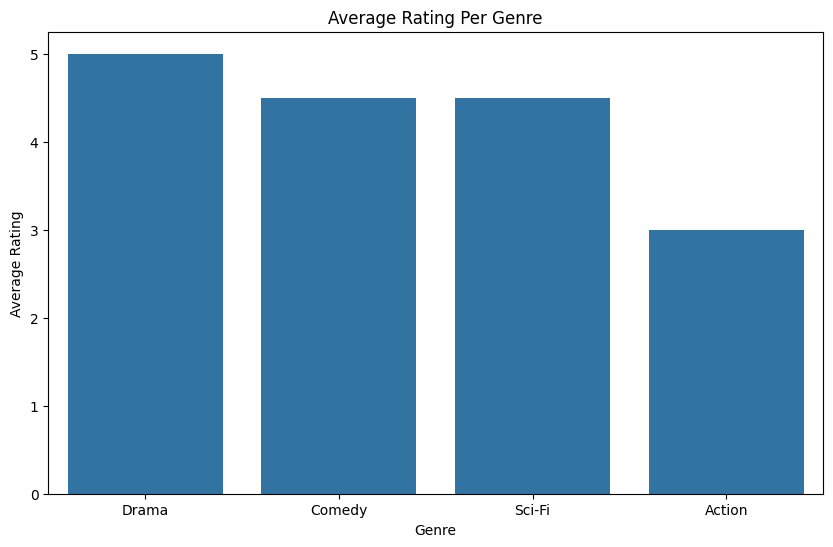

In [13]:
# Calculate average rating per genre
genre_ratings = spark.sql("""
    SELECT m.genre, AVG(r.rating) as avg_rating
    FROM ratings r
    JOIN movies m ON r.movie_id = m.movie_id
    GROUP BY m.genre
    ORDER BY avg_rating DESC
""")

# Convert to Pandas for plotting
genre_ratings_pd = genre_ratings.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x="genre", y="avg_rating", data=genre_ratings_pd)
plt.title("Average Rating Per Genre")
plt.xlabel("Genre")
plt.ylabel("Average Rating")
plt.show()

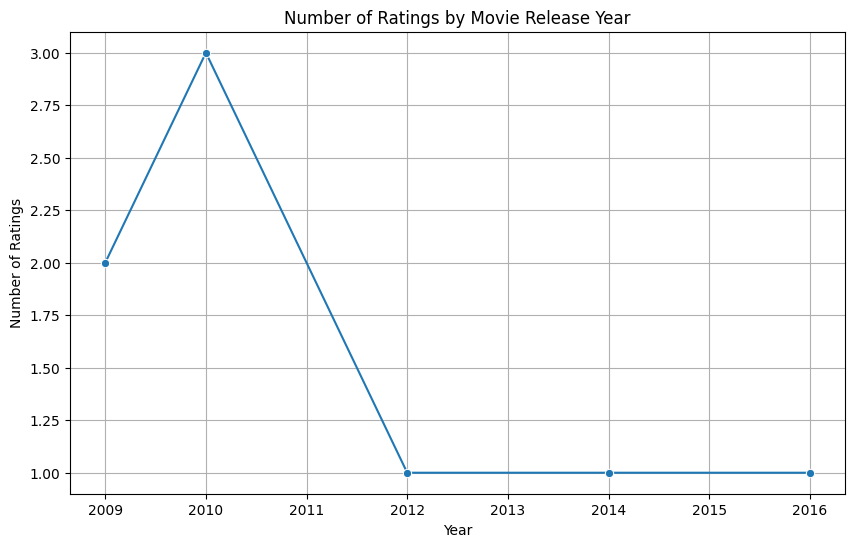

In [14]:
# Calculate number of ratings per year
ratings_per_year = spark.sql("""
    SELECT m.year, COUNT(r.rating) as num_ratings
    FROM ratings r
    JOIN movies m ON r.movie_id = m.movie_id
    GROUP BY m.year
    ORDER BY m.year
""")

# Convert to Pandas for plotting
ratings_per_year_pd = ratings_per_year.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(x="year", y="num_ratings", data=ratings_per_year_pd, marker='o')
plt.title("Number of Ratings by Movie Release Year")
plt.xlabel("Year")
plt.ylabel("Number of Ratings")
plt.grid(True)
plt.show()

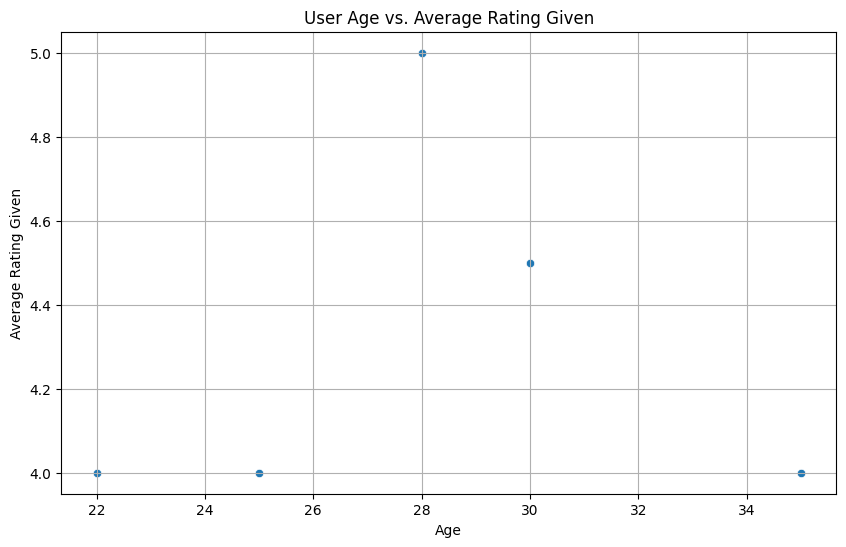

In [15]:
# Calculate average rating given by each user
avg_rating_by_user = spark.sql("""
    SELECT u.user_id, u.age, AVG(r.rating) as avg_rating_given
    FROM users u
    JOIN ratings r on u.user_id = r.user_id
    GROUP BY u.user_id, u.age
""")

# Convert to Pandas for plotting
avg_rating_by_user_pd = avg_rating_by_user.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x="age", y="avg_rating_given", data=avg_rating_by_user_pd)
plt.title("User Age vs. Average Rating Given")
plt.xlabel("Age")
plt.ylabel("Average Rating Given")
plt.grid(True)
plt.show()